In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torch_geometric
from torch.utils.data import Subset, Dataset
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import networkx as nx
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import math
from einops import rearrange
from models_coarsen.gnet_coarsening import Sn_coarsen_layer, Sn_coarsen_net
from models_coarsen.gnet_coarsen_utils import get_clusters, get_cluster_idxs, \
                           get_masked_images, generate_grid_graph, \
                           prepare_data, run_exp
# reproducibility
np.random.seed(0)

torch.cuda.is_available()


True

## Set-up
- x: image
- y: rotated(image) + Gaussian_noise

In [2]:
#Load MNIST
MNIST_flag = False #True #False - FashionMNIST
subset_flag = True
N = 28

input_size  = N*N  # images are 28x28 pixels
output_size = 10      # there are 10 classes
noise_flag = True

if MNIST_flag:
    transformations = transforms.Compose([
                        transforms.Resize((N, N)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])  
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False,transform=transformations)
    testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformations)

else: #FashionMNIST
    transformations = transforms.Compose([
                        transforms.Resize((N, N)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                    ])      
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True,transform=transformations)
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transformations)



##TO-DO: subset
if MNIST_flag:
    train_idx, validation_idx = train_test_split(np.arange(len(trainset)),
                                             train_size=100, #test_size=0.99,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=trainset.targets)
else:
    train_idx, validation_idx = train_test_split(np.arange(len(trainset)),
                                             train_size=100, #600,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=trainset.targets)
# Subset dataset for train and val
train_subset = Subset(trainset, train_idx)
validation_dataset = Subset(trainset, validation_idx) #NOT-USE


if subset_flag:
  train_loader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
else:
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False)

test_idx, test_rest_idx = train_test_split(np.arange(len(testset)),
                                             test_size=0.9,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=testset.targets)  
test_subset = Subset(testset, test_idx)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)
print(f"training_size={len(train_subset)}, test_size={len(test_subset)}")


training_size=100, test_size=1000


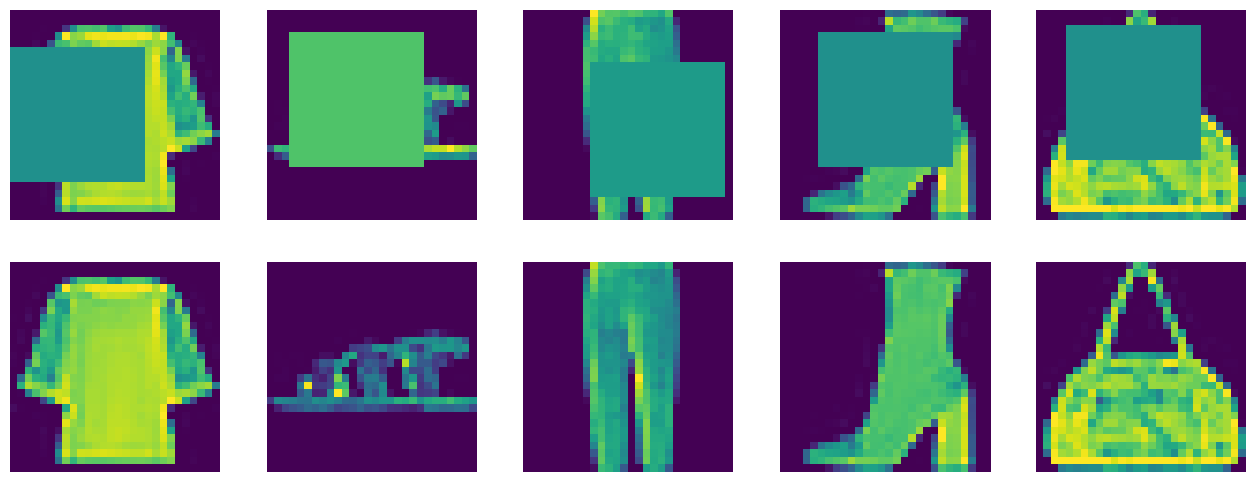

In [3]:
train_y, _ = next(iter(train_loader))
train_x = get_masked_images(train_y, mask_size=14 if MNIST_flag else 18)
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    #x, y = train_loader.dataset.__getitem__(i)
    #x, y = next(iter(train_loader))
    #x, label = train_loader.dataset.__getitem__(i)
    x = train_x[i] #gauss_noise_tensor(rotate_img(x))
    if MNIST_flag:
        plt.imshow(x.squeeze().numpy())
    else:
        plt.imshow(x.permute(1,2,0).numpy())
    plt.axis('off')

for j in range(5):
    plt.subplot(2, 5, j + 6)
    #y, label = train_loader.dataset.__getitem__(j)
    y = train_y[j]#add_gauss_noise(adjust_contrast(x))
    #y = add_gauss_noise(gamma_correct(x))
    if MNIST_flag:
        plt.imshow(y.squeeze().numpy())
    else:
        plt.imshow(y.permute(1,2,0).numpy())

    plt.axis('off')    

In [4]:
#initialize new model instances
gpu_id = 1
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
in_features = 1
out_features = 1
lr = 0.01 #for SGD seems 0.1 also works
n_epochs = 500
total_runs = 3 

if MNIST_flag:
    print(f"running MNIST")
    mask_size = 14 #"gamma" #"rotate" #"contrast"

else:
    print(f"running fashion!")
    mask_size = 20 #"gamma" #"rotate" #"contrast"

cluster_sizes = [1, 2, 4, 7, 14, 28]
#save

for run in range(total_runs):
#for run in range(total_runs-2, total_runs):
    results_val = dict()
    results_test = dict()

    print(f"running run={run}...")
    train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(train_loader, test_loader, device, mask_size)

    for size in cluster_sizes:
        print(f"Coarsen Sn: {size} x {size} clusters")
        torch.manual_seed(run)
        cluster_ids = get_cluster_idxs(N,size)
        model_coarsen_Sn = Sn_coarsen_layer(cluster_ids, in_features, out_features)
        model_coarsen_Sn.to(device)
        #train_loss, test_loss
        best_val, best_test, model_coarsen_Sn = run_exp(model_coarsen_Sn, train_x, train_y, val_x, val_y, \
                                                            test_x, test_y, device, \
                                                            n_epochs=n_epochs, run=run, lr=lr, mask_size=mask_size)  
        name = f"Sn_coarsen{size}"
        results_val[name] = best_val.item()
        results_test[name] = best_test.item()

    if MNIST_flag:
        save_path = f"inpainting_results/linear/mnist_{mask_size}_run={run}"
    else:
        save_path = f"inpainting_results/linear/fashion_{mask_size}_run={run}"
    

    pickle.dump(results_test, open(f"{save_path}_test.pkl", "wb"))
    pickle.dump(results_val, open(f"{save_path}_val.pkl", "wb"))



running fashion!
running run=0...


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
